# Vision Transformer (ViT) Interactive Demo

**Course:** DS 5690 - Transformers  
**Paper:** "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"

---

## Overview

This notebook demonstrates the functionality of Vision Transformers (ViT), showing how they:
1. Split images into patches
2. Process them through transformer layers
3. Perform image classification
4. Use attention mechanisms to focus on important regions

**Key Architecture Details:**
- Model: ViT-B/16 (Base model with 16×16 patches)
- Input: 224×224 images
- Patch size: 16×16 pixels
- Embedding dimension: 768
- Number of layers: 12
- Number of attention heads: 12

## Step 1: Import Required Libraries

We'll need PyTorch for the model, torchvision for pre-trained weights, and PIL for image handling.

In [52]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import urllib.request

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.5.1
CUDA available: False


## Step 2: Load Pre-trained ViT Model

We'll load the ViT-B/16 model pre-trained on ImageNet-1K. This model has been trained on over 1 million images across 1000 classes.

In [53]:
def load_pretrained_vit():
    # load pre-trained ViT-B/16 model
    weights = ViT_B_16_Weights.IMAGENET1K_V1
    model = vit_b_16(weights=weights)
    model.eval()  # Set to evaluation mode
    
    num_params = sum(p.numel() for p in model.parameters())

    return model, weights

# load the model
model, weights = load_pretrained_vit()
preprocess = weights.transforms()

## Step 3: Load and Display Test Images

Let's load some example images to test our model. You can use either:
1. **Local images** from your computer
2. **URLs** from the internet

**Tip:** For reliable results, save some test images locally and update the paths below!

✓ Downloaded: cat
✓ Loaded: Cat


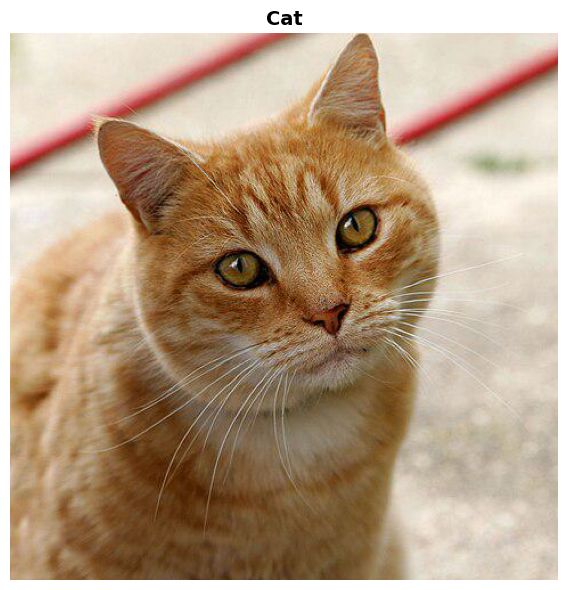


Total test images: 1


In [54]:
def load_image_from_url(url):
    # add headers to avoid 403 errors from some websites
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        req = urllib.request.Request(url, headers=headers)
        with urllib.request.urlopen(req, timeout=10) as response:
            img = Image.open(BytesIO(response.read()))
        return img
    except Exception as e:
        print(f"Error loading image from {url}: {e}")
        raise

def load_image(source):
    import os
    
    # check if it's a local file
    if os.path.exists(source):
        return Image.open(source)
    # otherwise, try to load from URL
    else:
        return load_image_from_url(source)


# download sample images
sample_images = {
    "cat": "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/481px-Cat03.jpg",
}

test_images = []

print("Downloading sample images...")
for name, url in sample_images.items():
    try:
        # download with headers
        img = load_image_from_url(url)
        # save temporarily
        filename = f"temp_{name}.jpg"
        img.save(filename)
        test_images.append({"source": filename, "description": name.capitalize()})
        print(f"✓ Downloaded: {name}")
    except Exception as e:
        print(f"✗ Failed to download {name}: {e}")

# OPTION 2: Use your own local images (RECOMMENDED)
# Uncomment and modify the paths below to use your own images:
# test_images = [
#     {"source": "path/to/your/cat.jpg", "description": "Cat"},
#     {"source": "path/to/your/dog.jpg", "description": "Dog"}
# ]

# load and display images
if not test_images:
    print("\n⚠ No images loaded. Please either:")
    print("  1. Uncomment OPTION 2 above and provide local image paths")
    print("  2. Check your internet connection")
else:
    fig, axes = plt.subplots(1, len(test_images), figsize=(12, 6))
    if len(test_images) == 1:
        axes = [axes]

    for idx, test_img in enumerate(test_images):
        try:
            img = load_image(test_img["source"])
            axes[idx].imshow(img)
            axes[idx].set_title(test_img["description"], fontsize=14, fontweight='bold')
            axes[idx].axis('off')
            print(f"✓ Loaded: {test_img['description']}")
        except Exception as e:
            axes[idx].text(0.5, 0.5, f"Failed to load\n{test_img['description']}", 
                          ha='center', va='center', fontsize=12)
            axes[idx].axis('off')
            print(f"✗ Failed: {test_img['description']} - {e}")

    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal test images: {len(test_images)}")

## Step 4: Understand Patch Embedding

**Key Concept:** ViT treats an image as a sequence of patches, similar to how NLP transformers treat text as a sequence of words.

For a 224×224 image with 16×16 patches:
- Number of patches per row: 224 ÷ 16 = 14
- Number of patches per column: 224 ÷ 16 = 14
- Total patches: 14 × 14 = 196
- Sequence length: 197 (196 patches + 1 CLS token)

In [55]:
def demonstrate_patch_embedding(image, patch_size=16):
    # resize to 224x224 if needed
    if image.size != (224, 224):
        image = image.resize((224, 224))
    
    # convert to tensor
    img_tensor = transforms.ToTensor()(image)
    C, H, W = img_tensor.shape
    
    # calculate number of patches
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    total_patches = num_patches_h * num_patches_w
    
    # reshape to patches
    patches = img_tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    patches = patches.contiguous().view(C, -1, patch_size, patch_size)
    patches = patches.permute(1, 0, 2, 3)  # (num_patches, C, patch_size, patch_size)
    
    return {
        "image": image,
        "image_size": (H, W),
        "patch_size": patch_size,
        "num_patches": (num_patches_h, num_patches_w),
        "total_patches": total_patches,
        "patches": patches,
        "patch_shape": patches.shape,
        "sequence_length": total_patches + 1  # +1 for CLS token
    }

# demonstrate on first image
img = load_image(test_images[0]["source"])
patch_info = demonstrate_patch_embedding(img)

print("Patch Embedding Information:")
print("=" * 50)
print(f"Original image size: {patch_info['image_size']}")
print(f"Patch size: {patch_info['patch_size']}×{patch_info['patch_size']}")
print(f"Number of patches: {patch_info['num_patches'][0]} × {patch_info['num_patches'][1]} = {patch_info['total_patches']}")
print(f"Sequence length (with CLS token): {patch_info['sequence_length']}")
print(f"Patch tensor shape: {patch_info['patch_shape']}")
print(f"  → (num_patches, channels, height, width)")

Patch Embedding Information:
Original image size: (224, 224)
Patch size: 16×16
Number of patches: 14 × 14 = 196
Sequence length (with CLS token): 197
Patch tensor shape: torch.Size([196, 3, 16, 16])
  → (num_patches, channels, height, width)


### Visualize Patch Division

Let's visualize how the image is divided into patches and show some individual patches.

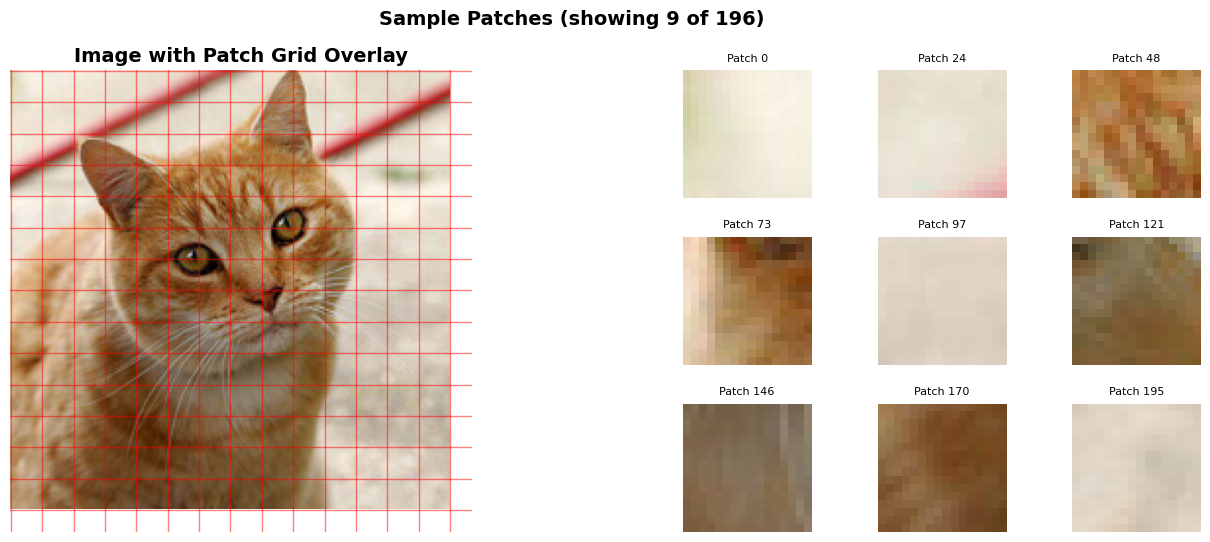

In [56]:
def visualize_patches(patch_info, num_samples=9):
    image = patch_info['image']
    patches = patch_info['patches']
    patch_size = patch_info['patch_size']
    num_patches_h, num_patches_w = patch_info['num_patches']

    # create figure with GridSpec for better control
    fig = plt.figure(figsize=(16, 6))
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.3)

    # Left: show image with grid overlay
    ax1 = fig.add_subplot(gs[0])
    ax1.imshow(image)
    ax1.set_title('Image with Patch Grid Overlay', fontsize=14, fontweight='bold')

    # draw grid
    for i in range(num_patches_h + 1):
        ax1.axhline(y=i * patch_size, color='red', linewidth=1, alpha=0.5)
    for j in range(num_patches_w + 1):
        ax1.axvline(x=j * patch_size, color='red', linewidth=1, alpha=0.5)

    ax1.axis('off')

    # Right: show sample patches in a grid
    grid_size = int(np.sqrt(num_samples))
    patch_indices = np.linspace(0, patches.shape[0] - 1, num_samples, dtype=int)

    # create nested GridSpec for patches
    gs_right = gs[1].subgridspec(grid_size, grid_size, hspace=0.3, wspace=0.3)

    for idx, patch_idx in enumerate(patch_indices):
        ax = fig.add_subplot(gs_right[idx // grid_size, idx % grid_size])
        patch = patches[patch_idx].permute(1, 2, 0).numpy()
        ax.imshow(patch)
        ax.set_title(f'Patch {patch_idx}', fontsize=8)
        ax.axis('off')

    plt.suptitle(f'Sample Patches (showing {num_samples} of {patches.shape[0]})',
                 fontsize=14, fontweight='bold', y=0.98)
    plt.show()

visualize_patches(patch_info)

## Step 5: Image Classification

Now let's use the ViT model to classify our test images. The model will output probabilities for each of the 1000 ImageNet classes.

In [57]:
def classify_image(model, image, preprocess, weights, top_k=5):
    # preprocess the image
    img_tensor = preprocess(image).unsqueeze(0)
    
    # run inference
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
    
    # get top-k predictions
    top_probs, top_indices = torch.topk(probabilities, top_k)
    
    # get class names
    categories = weights.meta["categories"]
    results = [
        (categories[idx], prob.item())
        for idx, prob in zip(top_indices, top_probs)
    ]
    
    return results

# classify all test images
print("Image Classification Results")
print("=" * 70)

for i, test_img in enumerate(test_images, 1):
    print(f"\nImage {i}: {test_img['description']}")
    print("-" * 70)
    
    # load and classify
    img = load_image(test_img["source"])
    results = classify_image(model, img, preprocess, weights, top_k=5)
    
    print("\nTop 5 Predictions:")
    for rank, (class_name, prob) in enumerate(results, 1):
        bar = '█' * int(prob * 50)
        print(f"  {rank}. {class_name:30s} {prob*100:5.2f}% {bar}")

Image Classification Results

Image 1: Cat
----------------------------------------------------------------------

Top 5 Predictions:
  1. tiger cat                      51.86% █████████████████████████
  2. Egyptian cat                   15.95% ███████
  3. tabby                          15.91% ███████
  4. lens cap                        0.19% 
  5. doormat                         0.15% 


### Visualize Classification Results

Let's create a bar chart to better visualize the predictions.

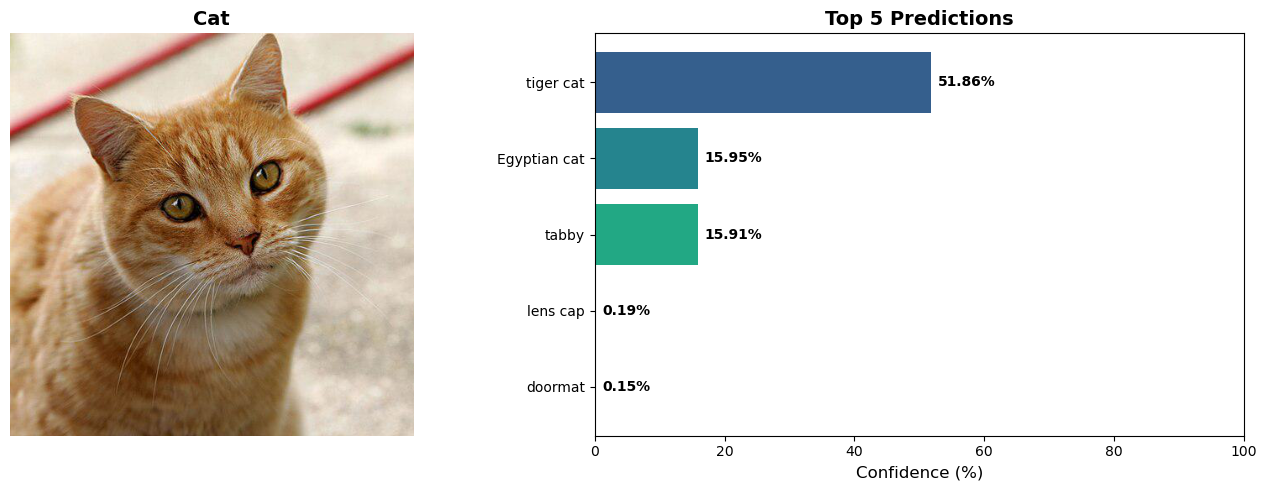

In [58]:
def visualize_predictions(test_images, model, preprocess, weights, top_k=5):
    fig, axes = plt.subplots(len(test_images), 2, figsize=(14, 5 * len(test_images)))
    
    if len(test_images) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, test_img in enumerate(test_images):
        # load image
        img = load_image(test_img["source"])
        
        # classify
        results = classify_image(model, img, preprocess, weights, top_k=top_k)
        
        # display image
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title(f'{test_img["description"]}', fontsize=14, fontweight='bold')
        axes[idx, 0].axis('off')
        
        # display predictions
        class_names = [r[0] for r in results]
        probabilities = [r[1] * 100 for r in results]
        
        colors = plt.cm.viridis(np.linspace(0.3, 0.9, top_k))
        bars = axes[idx, 1].barh(range(top_k), probabilities, color=colors)
        axes[idx, 1].set_yticks(range(top_k))
        axes[idx, 1].set_yticklabels(class_names)
        axes[idx, 1].set_xlabel('Confidence (%)', fontsize=12)
        axes[idx, 1].set_title('Top 5 Predictions', fontsize=14, fontweight='bold')
        axes[idx, 1].set_xlim(0, 100)
        axes[idx, 1].invert_yaxis()
        
        # add percentage labels
        for i, (bar, prob) in enumerate(zip(bars, probabilities)):
            axes[idx, 1].text(prob + 1, i, f'{prob:.2f}%', 
                            va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(test_images, model, preprocess, weights)

## Step 6: Attention Mechanism Analysis

One of the key features of ViT is the self-attention mechanism. Let's extract and analyze the attention weights to understand what the model is focusing on.

In [59]:
def extract_attention_weights(model, image, preprocess):
    # preprocess the image
    img_tensor = preprocess(image).unsqueeze(0)
    
    # storage for attention weights
    attention_weights = []
    
    # hook function to intercept attention computation
    def attention_hook(module, input, output):
        # get the input to the attention layer
        x = input[0]
        
        B, N, C = x.shape
        
        # manually compute attention weights
        # this replicates what happens inside MultiheadAttention
        qkv = torch.nn.functional.linear(x, module.in_proj_weight, module.in_proj_bias)
        qkv = qkv.reshape(B, N, 3, module.num_heads, C // module.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # compute attention scores
        attn = (q @ k.transpose(-2, -1)) / (k.shape[-1] ** 0.5)
        attn = torch.nn.functional.softmax(attn, dim=-1)
        
        # store the attention weights (before dropout)
        attention_weights.append(attn.detach().cpu())
    
    # register hooks
    hooks = []
    for block in model.encoder.layers:
        hook = block.self_attention.register_forward_hook(attention_hook)
        hooks.append(hook)
    
    # forward pass
    with torch.no_grad():
        _ = model(img_tensor)
    
    # remove hooks
    for hook in hooks:
        hook.remove()
    
    return attention_weights

# extract attention weights for first image
print("Extracting attention weights from ViT model...")
print("(This may take a moment...)")

try:
    img = load_image(test_images[0]["source"])
    attention_weights = extract_attention_weights(model, img, preprocess)
    
    print("✓ Successfully extracted attention weights!\n")
    print("Attention Mechanism Analysis")
    print("=" * 70)
    print(f"Number of transformer layers: {len(attention_weights)}")
    
    if attention_weights and attention_weights[0] is not None:
        print(f"Attention tensor shape: {attention_weights[0].shape}")
        print(f"  → (batch_size, num_heads, seq_length, seq_length)")
        print(f"\nEach attention matrix shows how much each patch attends to every other patch.")
        print(f"The sequence includes {attention_weights[0].shape[2] - 1} image patches + 1 CLS token.")
    else:
        print("⚠ No attention weights were captured.")
        
except Exception as e:
    print(f"✗ Error extracting attention weights: {e}")
    print("\nNote: Attention visualization is optional. You can continue with the other cells.")

Extracting attention weights from ViT model...
(This may take a moment...)
✓ Successfully extracted attention weights!

Attention Mechanism Analysis
Number of transformer layers: 12
Attention tensor shape: torch.Size([1, 12, 197, 197])
  → (batch_size, num_heads, seq_length, seq_length)

Each attention matrix shows how much each patch attends to every other patch.
The sequence includes 196 image patches + 1 CLS token.


### Visualize Attention Maps

Let's visualize the attention patterns from different layers and heads. We'll focus on how the CLS token attends to different patches.

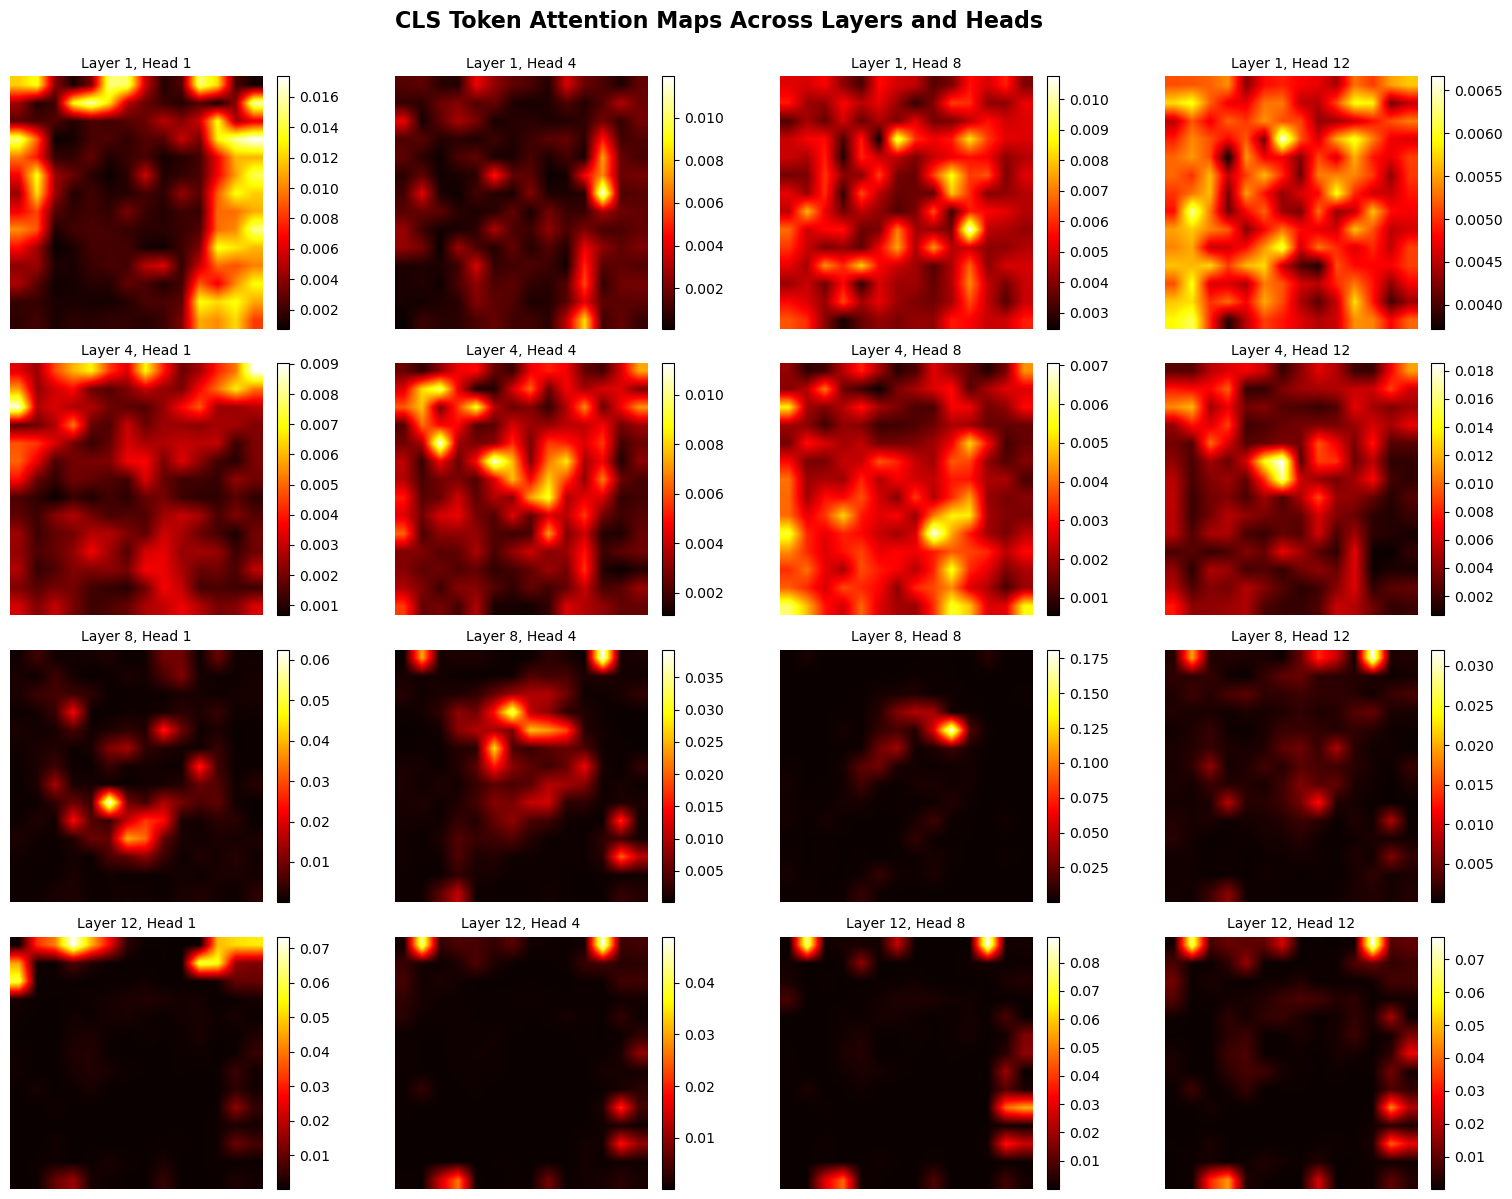

In [60]:
def visualize_attention_maps(attention_weights, num_layers=4, num_heads=4):
    if not attention_weights or attention_weights[0] is None:
        print("⚠ No attention weights available to visualize.")
        return
    
    # select layers to visualize (evenly distributed)
    total_layers = len(attention_weights)
    layer_indices = np.linspace(0, total_layers - 1, num_layers, dtype=int)
    
    # create figure
    fig, axes = plt.subplots(num_layers, num_heads, figsize=(16, 12))
    
    for row_idx, layer_idx in enumerate(layer_indices):
        attn = attention_weights[layer_idx][0]  # Remove batch dimension
        
        # select heads to visualize
        total_heads = attn.shape[0]
        head_indices = np.linspace(0, total_heads - 1, num_heads, dtype=int)
        
        for col_idx, head_idx in enumerate(head_indices):
            # get attention from CLS token (index 0) to all patches
            cls_attention = attn[head_idx, 0, 1:].numpy()  # Skip CLS token itself
            
            # reshape to 2D (14x14 for ViT-B/16)
            patch_size = int(np.sqrt(len(cls_attention)))
            attn_map = cls_attention.reshape(patch_size, patch_size)
            
            # plot
            ax = axes[row_idx, col_idx]
            im = ax.imshow(attn_map, cmap='hot', interpolation='bilinear')
            ax.set_title(f'Layer {layer_idx + 1}, Head {head_idx + 1}', fontsize=10)
            ax.axis('off')
            
            # add colorbar
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.suptitle('CLS Token Attention Maps Across Layers and Heads', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# visualize if attention weights are available
if 'attention_weights' in locals() and attention_weights:
    visualize_attention_maps(attention_weights)
else:
    print("⚠ Skipping attention visualization - run the previous cell first to extract attention weights.")

### Attention Rollout

Attention rollout combines attention weights across all layers to show which image regions the model focuses on for its final prediction.

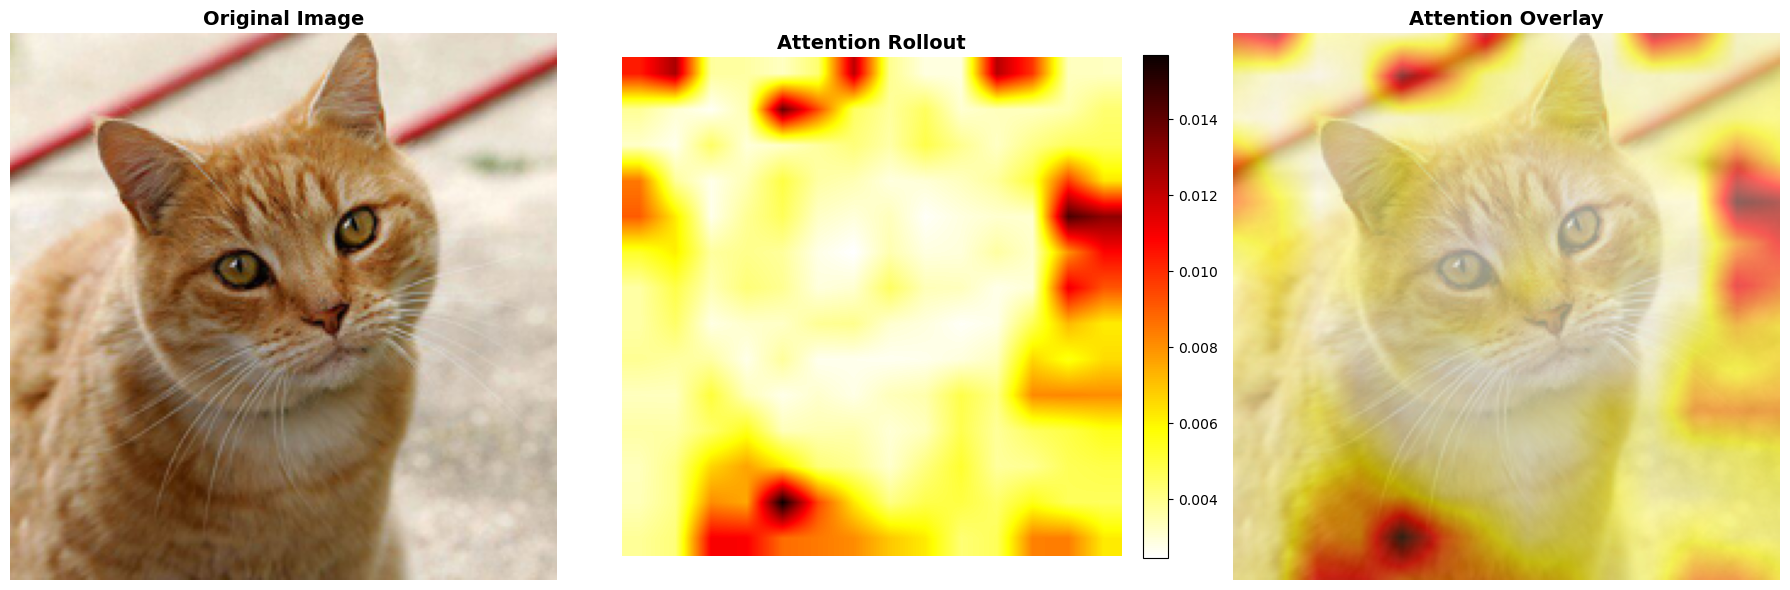

In [61]:
def compute_attention_rollout(attention_weights):
    if not attention_weights or attention_weights[0] is None:
        return None
    
    # Average attention weights across heads for each layer
    averaged_attentions = []
    for attn in attention_weights:
        # attn shape: (batch, heads, seq_len, seq_len)
        avg_attn = attn[0].mean(dim=0)  # Average across heads
        averaged_attentions.append(avg_attn)
    
    # Add identity matrix to preserve information
    rollout = averaged_attentions[0]
    for attn in averaged_attentions[1:]:
        # Add residual connection
        attn = attn + torch.eye(attn.shape[0])
        attn = attn / attn.sum(dim=-1, keepdim=True)
        
        # Multiply with previous rollout
        rollout = torch.matmul(attn, rollout)
    
    # Get CLS token attention to patches
    cls_rollout = rollout[0, 1:]  # Skip CLS token itself
    
    return cls_rollout.numpy()

def visualize_attention_rollout(img, attention_weights):
    """
    Visualize attention rollout overlaid on the original image.
    """
    # Compute rollout
    rollout = compute_attention_rollout(attention_weights)
    
    if rollout is None:
        print("⚠ No attention weights available for rollout visualization.")
        return
    
    # Reshape to 2D
    patch_size = int(np.sqrt(len(rollout)))
    attn_map = rollout.reshape(patch_size, patch_size)
    
    # Resize image to 224x224
    if img.size != (224, 224):
        img = img.resize((224, 224))
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original image
    axes[0].imshow(img)
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Attention map - using reversed hot colormap (light to dark)
    im = axes[1].imshow(attn_map, cmap='hot_r', interpolation='bilinear')
    axes[1].set_title('Attention Rollout', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Overlay
    axes[2].imshow(img)
    # Resize attention map to match image
    from scipy.ndimage import zoom
    attn_resized = zoom(attn_map, (224 / patch_size, 224 / patch_size), order=1)
    axes[2].imshow(attn_resized, cmap='hot_r', alpha=0.6, interpolation='bilinear')
    axes[2].set_title('Attention Overlay', fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize attention rollout if weights are available
if 'attention_weights' in locals() and attention_weights and 'img' in locals():
    visualize_attention_rollout(img, attention_weights)
else:
    print("⚠ Skipping attention rollout - run the previous cells first to extract attention weights.")

## Step 7: Try Your Own Image!

You can test the model on your own images by providing a URL or local file path.

Custom Image Classification
Image URL: https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/481px-Cat03.jpg



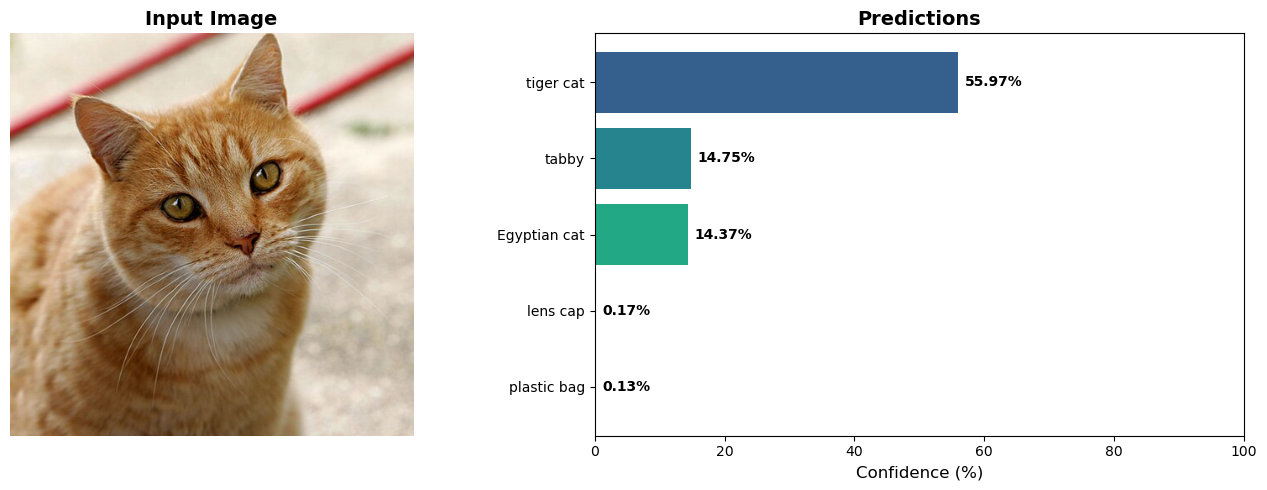

In [62]:
# replace with your own image URL
custom_image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/481px-Cat03.jpg"

print("Custom Image Classification")
print("=" * 70)
print(f"Image URL: {custom_image_url}\n")

# load and classify
custom_img = load_image_from_url(custom_image_url)
results = classify_image(model, custom_img, preprocess, weights, top_k=5)

# display results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].imshow(custom_img)
axes[0].set_title('Input Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

class_names = [r[0] for r in results]
probabilities = [r[1] * 100 for r in results]

colors = plt.cm.viridis(np.linspace(0.3, 0.9, 5))
bars = axes[1].barh(range(5), probabilities, color=colors)
axes[1].set_yticks(range(5))
axes[1].set_yticklabels(class_names)
axes[1].set_xlabel('Confidence (%)', fontsize=12)
axes[1].set_title('Predictions', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 100)
axes[1].invert_yaxis()

for i, (bar, prob) in enumerate(zip(bars, probabilities)):
    axes[1].text(prob + 1, i, f'{prob:.2f}%', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## References

**Paper**: Dosovitskiy, A., et al. (2020). "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale." *ICLR 2021*.

**Links**:
- [Original Paper](https://arxiv.org/abs/2010.11929)
- [PyTorch Implementation](https://pytorch.org/vision/stable/models/vision_transformer.html)
- [Google Research Blog](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html)